## Spark

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('tree').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/25 18:15:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pyspark
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

In [3]:
df = spark.read.csv("../../../data/p_dsi/big_data_scaling_sp23/project/DT-MapReduce/adult.csv", inferSchema = True, header = True)

In [4]:
df

DataFrame[age: int, workclass: string, fnlwgt: int, education: string, education.num: int, marital.status: string, occupation: string, relationship: string, race: string, sex: string, capital.gain: int, capital.loss: int, hours.per.week: int, native.country: string, income: string]

In [5]:
df.show(10)

+---+-----------+------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|age|  workclass|fnlwgt|   education|education.num|marital.status|       occupation|  relationship| race|   sex|capital.gain|capital.loss|hours.per.week|native.country|income|
+---+-----------+------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| 90|          ?| 77053|     HS-grad|            9|       Widowed|                ?| Not-in-family|White|Female|           0|        4356|            40| United-States| <=50K|
| 82|    Private|132870|     HS-grad|            9|       Widowed|  Exec-managerial| Not-in-family|White|Female|           0|        4356|            18| United-States| <=50K|
| 66|          ?|186061|Some-college|           10|       Widowed|                ?|     Unmarried|Black|Female|        

In [6]:
train, test = df.randomSplit([0.8,0.2])

In [7]:
gender_indexer = StringIndexer(inputCol='workclass',outputCol='wc_fixed')

In [8]:
df_fixed = gender_indexer.fit(df).transform(df)

In [9]:
df_fixed.show(10)

+---+-----------+------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+--------+
|age|  workclass|fnlwgt|   education|education.num|marital.status|       occupation|  relationship| race|   sex|capital.gain|capital.loss|hours.per.week|native.country|income|wc_fixed|
+---+-----------+------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+--------+
| 90|          ?| 77053|     HS-grad|            9|       Widowed|                ?| Not-in-family|White|Female|           0|        4356|            40| United-States| <=50K|     3.0|
| 82|    Private|132870|     HS-grad|            9|       Widowed|  Exec-managerial| Not-in-family|White|Female|           0|        4356|            18| United-States| <=50K|     0.0|
| 66|          ?|186061|Some-college|           10|       Widowed|         

### Pandas

In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, Normalizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import janitor

In [11]:
df_pd = pd.read_csv("../../../data/p_dsi/big_data_scaling_sp23/project/DT-MapReduce/adult.csv").clean_names()

In [12]:
df_pd

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [13]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_categorical_dtype

In [14]:
df_pd["income"].unique()

array(['<=50K', '>50K'], dtype=object)

In [15]:
df_pd["income"] = df_pd["income"].replace(["<=50K",">50K"], [0,1])

In [16]:
df_pd["income"].unique()

array([0, 1])

In [17]:
train, test = train_test_split(df_pd, random_state = 10, train_size = 0.8, stratify = df_pd["income"])

### Data Deduplication

In [18]:
train_0 = train[train["income"] == 0]
train_0.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
30190,53,Private,72257,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,0
19237,49,Private,102945,7th-8th,4,Widowed,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,0
25502,38,Private,193372,Some-college,10,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,0
17492,40,Private,188942,Some-college,10,Married-civ-spouse,Sales,Wife,Black,Female,0,0,40,Puerto-Rico,0
27373,60,?,188236,HS-grad,9,Divorced,?,Not-in-family,White,Female,0,0,40,United-States,0


In [19]:
train_1 = train[train["income"] == 1]
train_1.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
1609,39,Private,190297,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,55,United-States,1
12039,42,Self-emp-inc,168071,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,43,United-States,1
24687,32,Private,340917,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,50,United-States,1
2719,36,Private,143486,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,7298,0,50,United-States,1
2871,40,Self-emp-not-inc,26892,Bachelors,13,Married-AF-spouse,Prof-specialty,Husband,White,Male,7298,0,50,United-States,1


In [20]:
train_0 = train_0.drop_duplicates()

### Class Balancing

In [21]:
#rand_list = list(np.random.randint(0, len(train_0), len(train_1)))

In [22]:
#train_0 = train_0.iloc[rand_list,]
#train_0.shape

In [23]:
train_new = pd.concat([train_0, train_1], axis = 0)
train_new.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
30190,53,Private,72257,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,0
19237,49,Private,102945,7th-8th,4,Widowed,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,0
25502,38,Private,193372,Some-college,10,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,0
17492,40,Private,188942,Some-college,10,Married-civ-spouse,Sales,Wife,Black,Female,0,0,40,Puerto-Rico,0
27373,60,?,188236,HS-grad,9,Divorced,?,Not-in-family,White,Female,0,0,40,United-States,0


In [24]:
x_train, y_train = train_new.drop("income", axis = 1), train_new["income"]
x_test, y_test = test.drop("income", axis = 1), test["income"]

In [25]:
num = []
cat = []
stri = []
columns = list(x_train.columns)
for col in columns:
    if is_numeric_dtype(x_train[col]):
        num.append(col)
    elif is_string_dtype(x_train[col]):
        stri.append(col)
    elif is_category_dtype(x_train[col]):
        cat.append(col)

In [26]:
num, stri, cat

(['age',
  'fnlwgt',
  'education_num',
  'capital_gain',
  'capital_loss',
  'hours_per_week'],
 ['workclass',
  'education',
  'marital_status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native_country'],
 [])

In [27]:
df_pd["native_country"].unique()

array(['United-States', '?', 'Mexico', 'Greece', 'Vietnam', 'China',
       'Taiwan', 'India', 'Philippines', 'Trinadad&Tobago', 'Canada',
       'South', 'Holand-Netherlands', 'Puerto-Rico', 'Poland', 'Iran',
       'England', 'Germany', 'Italy', 'Japan', 'Hong', 'Honduras', 'Cuba',
       'Ireland', 'Cambodia', 'Peru', 'Nicaragua', 'Dominican-Republic',
       'Haiti', 'El-Salvador', 'Hungary', 'Columbia', 'Guatemala',
       'Jamaica', 'Ecuador', 'France', 'Yugoslavia', 'Scotland',
       'Portugal', 'Laos', 'Thailand', 'Outlying-US(Guam-USVI-etc)'],
      dtype=object)

In [28]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [29]:
ct = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown="ignore"), stri), ("min_max", MinMaxScaler(), num)])

In [30]:
pipeline = Pipeline([("ct", ct), ("dc", DecisionTreeClassifier(criterion="entropy"))])

In [31]:
import numpy as np
max_features = list(np.arange(3,14))
max_depth = list(np.arange(3,13))

In [32]:
param_grid = [{"dc__max_features":max_features, "dc__max_depth": max_depth}]

In [33]:
grid_search = GridSearchCV(pipeline, param_grid, cv = 5)

In [34]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital_status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native_country']),
                                         

In [35]:
grid_search.best_params_

{'dc__max_depth': 12, 'dc__max_features': 13}

In [36]:
grid_search.best_score_

0.8451191881610358

In [37]:
result = pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score", ascending = True)

In [38]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dc__max_depth,param_dc__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
109,0.109924,0.004689,0.017874,0.000525,12,13,"{'dc__max_depth': 12, 'dc__max_features': 13}",0.850394,0.855579,0.841559,0.843834,0.834230,0.845119,0.007350,1
97,0.106060,0.005105,0.018092,0.000359,11,12,"{'dc__max_depth': 11, 'dc__max_features': 12}",0.844824,0.847705,0.840023,0.836151,0.826738,0.839088,0.007337,2
107,0.101505,0.008367,0.016792,0.000565,12,11,"{'dc__max_depth': 12, 'dc__max_features': 11}",0.848857,0.845400,0.841367,0.825970,0.831925,0.838704,0.008522,3
96,0.098979,0.004823,0.017998,0.000314,11,11,"{'dc__max_depth': 11, 'dc__max_features': 11}",0.819666,0.828692,0.849433,0.844218,0.844218,0.837246,0.011207,4
94,0.091218,0.003997,0.016863,0.000749,11,9,"{'dc__max_depth': 11, 'dc__max_features': 9}",0.850010,0.836950,0.839063,0.827699,0.831925,0.837129,0.007559,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.075248,0.003459,0.019441,0.001213,3,10,"{'dc__max_depth': 3, 'dc__max_features': 10}",0.759939,0.776455,0.762819,0.772378,0.763926,0.767103,0.006246,106
2,0.072331,0.001136,0.019022,0.000529,3,5,"{'dc__max_depth': 3, 'dc__max_features': 5}",0.781448,0.758978,0.763587,0.769113,0.759316,0.766489,0.008330,107
15,0.074313,0.003081,0.018876,0.000661,4,7,"{'dc__max_depth': 4, 'dc__max_features': 7}",0.769349,0.759170,0.776455,0.759124,0.767960,0.766412,0.006594,108
3,0.073317,0.002742,0.018996,0.000909,3,6,"{'dc__max_depth': 3, 'dc__max_features': 6}",0.764932,0.771269,0.758978,0.772378,0.759124,0.765336,0.005727,109


In [39]:
model = grid_search.best_estimator_

In [40]:
pred = model.predict(x_test)

In [41]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4945
           1       0.77      0.48      0.59      1568

    accuracy                           0.84      6513
   macro avg       0.81      0.72      0.75      6513
weighted avg       0.83      0.84      0.83      6513



In [42]:
conf = confusion_matrix(y_test,pred)

<AxesSubplot:>

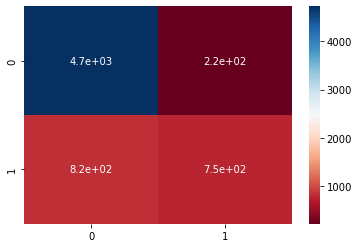

In [43]:
sns.heatmap(conf, annot = True, cmap = "RdBu")